In [ ]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split

from nltk.corpus import sentiwordnet as swn
nltk.download('sentiwordnet')
nltk.download('punkt')

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


import numpy as np
from matplotlib import pyplot as plt


import re
import unicodedata

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 2 a)


### Train/Test Splitting

In [ ]:
positius = mr.fileids('pos')
negatius = mr.fileids('neg')
_positius = [mr.raw(p) for p in positius]
_negatius = [mr.raw(p) for p in negatius]

#com que s'ha de preservar l'ordre de positius i negatius, primer divideixo en train, val i test i després faig merge.

train_pos, test_pos = train_test_split(_positius, test_size = 0.2, random_state = 23122003)

train_neg, test_neg = train_test_split(_negatius, test_size = 0.2, random_state = 23122003)

train = train_pos.copy()  
train.extend(train_neg) 

test = test_pos.copy()  
test.extend(test_neg)


### Preprocessament comú

In [ ]:
def preprocessador(sent):
  # Eliminació de caràcters especials (Signes de puntuació, nombres...)
  text_without_special_chars = re.sub(r"\d+|[^\w\d'\s]", '', sent)

  # Eliminació de caràcters no ASCII
  text_ascii_only = unicodedata.normalize('NFKD', text_without_special_chars).encode('ascii', 'ignore').decode('utf-8')
  
  # Canvi de dobles espais a un sol
  text_single_space = re.sub("  ",' ',text_ascii_only)

  # Conversió del text a lletra estrictament minúscula 
  text_lower = text_single_space.lower()

  # Eliminació del caràcter '\n'
  text_cleaned = text_lower.replace('\n', '')

  return text_cleaned

train_preprocessat = []
for doc in train:
  train_preprocessat.append(preprocessador(doc))

test_preprocessat = []
for doc in test:
  test_preprocessat.append(preprocessador(doc))
  

# Baseline model

### Lesk Synsets way

In [ ]:
llista_syn = [ [] for _ in range(len(train_preprocessat)) ]
i=0
for review in train:
    tokens = nltk.word_tokenize(review)
    for token in tokens:
        synset = nltk.wsd.lesk(review, token)
        if synset is not None:
            llista_syn[i].append(synset)
    
    i+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


KeyboardInterrupt: ignored

In [ ]:
vectorizer = CountVectorizer(analyzer = lambda sent: sent, max_df=0.85, min_df=0.05)

X = vectorizer.fit_transform(llista_syn)
X_train_lesk = pd.DataFrame(X.toarray())

### Lemmatized words way

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

train_lemmatitzat = []*len(train_preprocessat)

for doc in train_preprocessat:
  p = nltk.pos_tag((doc).split())
  train_lemmatitzat.append([lemmatize(pair) for pair in p])

In [ ]:
countvectorizer_lem = CountVectorizer(analyzer = lambda sent: sent, stop_words='english', max_df=0.85, min_df=0.05)
X = countvectorizer_lem.fit_transform(train_lemmatitzat)
X_train_word = pd.DataFrame(X.toarray())

### 3 Synsets most frequent way

In [ ]:
from nltk.corpus import wordnet as wn

countvectorizer_5 = CountVectorizer(stop_words='english',max_df=0.85, min_df = 0.05)
X = countvectorizer_5.fit_transform(train_preprocessat)
names = countvectorizer_5.get_feature_names_out()

paraules = {}

for name in names:
    paraules[name] = []
    for s in wn.synsets(name):
        aparicions = 0
        for l in s.lemmas():
            aparicions += l.count()
        paraules[name].append((s,aparicions))

for name in paraules:
    paraules[name].sort(key=lambda x: x[1], reverse=True)

for name in paraules:
    paraules[name] = paraules[name][:3]

In [ ]:
synsets = set(synset[0] for synset_list in paraules.values() for synset in synset_list)
lsynsets = list(synsets)

X = pd.DataFrame(X.toarray())

d1 = {}

for synset in lsynsets:
    d1[synset] = [0]*len(X.index)

for fila in range(len(X.index)):
    for paraula in range(len(names)):
        for syn in paraules[names[paraula]]:
            d1[syn[0]][fila] += X[paraula][fila]


In [ ]:
X_train_5_syn = pd.DataFrame(d1)

**Train and test definition**

In [ ]:
labels = [1]*800 + [0]*800

#X_train_5_syn
#---------------------------------------------------------------------------------------------------------

X_train_5 = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_train_5_syn], axis=1)
X_train_5 = X_train_5.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_train_5 = X_train_5['sentiment']
X_train_5.drop('sentiment', axis=1,inplace = True)
#---------------------------------------------------------------------------------------------------------

#X_train_lesk
#---------------------------------------------------------------------------------------------------------
X_train_l = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_train_lesk], axis=1)
X_train_l = X_train_l.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_train_l = X_train_l['sentiment']
X_train_l.drop('sentiment', axis=1,inplace = True)
#---------------------------------------------------------------------------------------------------------

#X_train_word_lematized
#---------------------------------------------------------------------------------------------------------
X_train_w = X_train_word

# separate the dataframe into two based on the first column value
df_1 = X_train_w.iloc[:800]
df_0 = X_train_w.iloc[ 800:]

# calculate the sum of each column in each dataframe
df_1_sum = df_1.sum()
df_0_sum = df_0.sum()

# initialize a list to store the column indices that meet the criteria
result = []

# loop through each column in df_1 and compare its sum with the corresponding column in df_0
for i in range(1, len(df_1_sum)-1):
    if abs(df_1_sum.iloc[i] - df_0_sum.iloc[i]) <= 15:
        result.append(i)

# delete the columns in the list result from the original dataframe
X_train_w.drop(X_train_w.columns[result], axis=1, inplace=True)

# create a new vocabulary dictionary without the words whose indices are in the result list
new_vocab = {k: v for k, v in countvectorizer_lem.vocabulary_.items() if v not in result}

# create a new dictionary that maps the original values to their new indices
new_indices = {k: i for i, k in enumerate(sorted(new_vocab.keys()))}

# create a new dictionary with the updated indices
new_vocab = {k: new_indices[k] for k in new_indices.keys()}

# create a new dataframe with the words reordered according to the new order of the CountVectorizer object's vocabulary
X_train_w_reordered = pd.DataFrame()

for colname in X_train_w.columns:
  word = list(countvectorizer_lem.vocabulary_.keys())[list(countvectorizer_lem.vocabulary_.values()).index(colname)]
  if word in new_vocab.keys():
    X_train_w_reordered[new_vocab[word]] = X_train_w[colname]

X_train_w_reordered = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_train_w_reordered], axis=1)

X_train_w_reordered = X_train_w_reordered.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_train_word_lematized = X_train_w_reordered['sentiment']
X_train_w_reordered.drop('sentiment', axis=1,inplace = True)

X_train_word_lematized = X_train_w_reordered

#---------------------------------------------------------------------------------------------------------

#X_train_world_original:

countvectorizer_original = CountVectorizer(stop_words='english', max_df=0.85, min_df=0.05)
X = countvectorizer_original.fit_transform(train_preprocessat)
X_train_world_original = pd.DataFrame(X.toarray())

X_train_world_original = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_train_world_original], axis=1)

X_train_world_original = X_train_world_original.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_train_world_original = X_train_world_original['sentiment']
X_train_world_original.drop('sentiment', axis=1,inplace = True)


In [ ]:
##test
labels = [1]*200 + [0]*200

#word original way
#---------------------------------------------------------------------------------------------------------
X = countvectorizer_original.transform(test_preprocessat)
X_test_world_original = pd.DataFrame(X.toarray())

X_test_world_original = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_test_world_original], axis=1)
X_test_world_original = X_test_world_original.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_test_world_original = X_test_world_original['sentiment']
X_test_world_original.drop('sentiment', axis=1,inplace = True)

#---------------------------------------------------------------------------------------------------------

#words lemmatized way
#---------------------------------------------------------------------------------------------------------

test_lemmatitzat = []*len(test_preprocessat)

for doc in test_preprocessat:
  p = nltk.pos_tag((doc).split())
  test_lemmatitzat.append([lemmatize(pair) for pair in p])

countvectorizer_lem.vocabulary_ = new_vocab

X = countvectorizer_lem.transform(test_lemmatitzat)
X_test_word = pd.DataFrame(X.toarray())

labels = [1]*200 + [0]*200

X_test_word_lematized = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_test_word], axis=1)
X_test_word_lematized = X_test_word_lematized.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_test_word_lematized = X_test_word_lematized['sentiment']
X_test_word_lematized.drop('sentiment', axis=1,inplace = True)

#---------------------------------------------------------------------------------------------------------


#5 synsets way
#---------------------------------------------------------------------------------------------------------
X = countvectorizer_5.transform(test_preprocessat)

X = pd.DataFrame(X.toarray())

d1 = {}

for synset in lsynsets:
    d1[synset] = [0]*len(X.index)

for fila in range(len(X.index)):
    for paraula in range(len(names)):
        for syn in paraules[names[paraula]]:
            d1[syn[0]][fila] += X[paraula][fila]

X_test_5_syn = pd.DataFrame(d1)

X_test_5 = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_test_5_syn], axis=1)
X_test_5 = X_test_5.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_test_5 = X_test_5['sentiment']
X_test_5.drop('sentiment', axis=1,inplace = True)

#---------------------------------------------------------------------------------------------------------

#lesk synsets way:
#---------------------------------------------------------------------------------------------------------

llista_syn_test = [ [] for _ in range(len(test_preprocessat)) ]

i=0
for review in test_preprocessat:
    tokens = nltk.word_tokenize(review)
    for token in tokens:
        synset = nltk.wsd.lesk(review, token)
        if synset is not None:
            llista_syn_test[i].append(synset)
    i+=1

X = vectorizer.transform(llista_syn_test)
X_test_l = pd.DataFrame(X.toarray())

X_test_lesk = pd.concat([pd.DataFrame(labels, columns = ['sentiment']), X_test_l], axis=1)
X_test_lesk = X_test_lesk.sample(frac=1, random_state = 23122003).reset_index(drop=True)
y_test_lesk = X_test_lesk['sentiment']
X_test_lesk.drop('sentiment', axis=1,inplace = True)

#---------------------------------------------------------------------------------------------------------


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline

# Define hyperparameters and search space for each dataset
hyperparams = {'max_depth': [5,8,10,12], 'min_samples_split': [2, 4, 6], "criterion" : ['gini','entropy']}

# Define parameter grids for each dataset
param_grid_5 = {'clf__' + key: hyperparams[key] for key in hyperparams}
param_grid_l = {'clf__' + key: hyperparams[key] for key in hyperparams}
param_grid_w_l = {'clf__' + key: hyperparams[key] for key in hyperparams}
param_grid_w_o = {'clf__' + key: hyperparams[key] for key in hyperparams}


# Define classifiers for each dataset
clf_5 = DecisionTreeClassifier(random_state=23122003)
clf_l = DecisionTreeClassifier(random_state=23122003)
clf_w_l = DecisionTreeClassifier(random_state=23122003)
clf_w_o = DecisionTreeClassifier(random_state=23122003)


# Define pipeline for each dataset
pipeline_5 = Pipeline(steps=[('clf', clf_5)])
pipeline_l = Pipeline(steps=[('clf', clf_l)])
pipeline_w_l = Pipeline(steps=[('clf', clf_w_l)])
pipeline_w_o = Pipeline(steps=[('clf', clf_w_o)])


# Define grid search with cross-validation for each dataset
grid_search_5 = GridSearchCV(pipeline_5, param_grid_5, cv=5, scoring='f1')
grid_search_l = GridSearchCV(pipeline_l, param_grid_l, cv=5, scoring='f1')
grid_search_w_l = GridSearchCV(pipeline_w_l, param_grid_w_l, cv=5, scoring='f1')
grid_search_w_o = GridSearchCV(pipeline_w_o, param_grid_w_o, cv=5, scoring='f1')


# Fit the grid search on each dataset
grid_search_5.fit(X_train_5, y_train_5)
grid_search_l.fit(X_train_l, y_train_l)
grid_search_w_l.fit(X_train_word_lematized, y_train_word_lematized)
grid_search_w_o.fit(X_train_world_original, y_train_world_original)


# Print the best hyperparameters and corresponding scores for each dataset
print('X_train_5_syn best hyperparameters:', grid_search_5.best_params_)
print('X_train_5_syn best F1 score:', grid_search_5.best_score_)

print('X_train_lesk best hyperparameters:', grid_search_l.best_params_)
print('X_train_lesk best F1 score:', grid_search_l.best_score_)

print('X_train_word_lematized best hyperparameters:', grid_search_w_l.best_params_)
print('X_train_word_lematized best F1 score:', grid_search_w_l.best_score_)

print('X_train_world_original best hyperparameters:', grid_search_w_o.best_params_)
print('X_train_world_original best F1 score:', grid_search_w_o.best_score_)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model with hyperparameters
rf_5 = DecisionTreeClassifier(random_state=23122003, criterion = 'gini', max_depth = 5, min_samples_split = 2)
rf_lesk = DecisionTreeClassifier(random_state=23122003, criterion = 'gini', max_depth = 5, min_samples_split = 2)
rf_word_lemmatized = DecisionTreeClassifier(random_state=23122003, criterion = 'entropy', max_depth = 8, min_samples_split = 4)
rf_word_original = DecisionTreeClassifier(random_state=23122003, criterion = 'entropy', max_depth = 8, min_samples_split = 2)

# Fit the model to the training data
rf_5.fit(X_train_5, y_train_5)
# Predict the labels of the test data
y_pred = rf_5.predict(X_test_5)
# Evaluate the model performance on the test data
accuracy = rf_5.score(X_test_5, y_test_5)
print("Decision tree accuracy of 5 synsets:", accuracy)

# Fit the model to the training data
rf_lesk.fit(X_train_l, y_train_l)
# Predict the labels of the test data
y_pred = rf_lesk.predict(X_test_lesk )
# Evaluate the model performance on the test data
accuracy = rf_lesk.score(X_test_lesk , y_test_lesk)
print("Decision tree accuracy:", accuracy)

# Fit the model to the training data
rf_word_lemmatized.fit(X_train_word_lematized, y_train_word_lematized)
# Predict the labels of the test data
y_pred = rf_word_lemmatized.predict(X_test_word_lematized)
# Evaluate the model performance on the test data
accuracy = rf_word_lemmatized.score(X_test_word_lematized , y_test_word_lematized)
print("Decision tree accuracy word lemmatized:", accuracy)

# Fit the model to the training data
rf_word_original.fit(X_train_world_original, y_train_world_original)
# Predict the labels of the test data
y_pred = rf_word_original.predict(X_test_world_original )
# Evaluate the model performance on the test data
accuracy = rf_word_original.score(X_test_world_original , y_test_world_original)
print("Decision tree accuracy word original:", accuracy)


***Random forest***

Random Hyperparameter Grid


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Cross-validation:

# Define the hyperparameter grid
n_estimators = [5,10,20,50,100]
max_features = ['log2', 'sqrt']
max_depth = [2,5,8,10]
min_samples_split = [2, 5, 7, 8,10,20]
min_samples_leaf = [1, 2, 4, 8, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

# Create a RandomForestClassifier object
rf = RandomForestClassifier()

# Define the RandomizedSearchCV object
rf_random_lesk = RandomizedSearchCV(estimator=rf, 
                            param_distributions=random_grid, 
                            n_iter=50, 
                            cv=3, 
                            scoring='accuracy',
                            random_state=23122003)

# Define the RandomizedSearchCV object
rf_random_5 = RandomizedSearchCV(estimator=rf, 
                            param_distributions=random_grid, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1',
                            random_state=23122003)
# Define the RandomizedSearchCV object
rf_random_w_o = RandomizedSearchCV(estimator=rf, 
                            param_distributions=random_grid, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1', 
                            random_state=23122003)

# Define the RandomizedSearchCV object
rf_random_w_l = RandomizedSearchCV(estimator=rf, 
                            param_distributions=random_grid, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1', 
                            random_state=23122003)


# Fit the grid search on each dataset
rf_random_5.fit(X_train_5, y_train_5)
rf_random_lesk.fit(X_train_l, y_train_l)
rf_random_w_o.fit(X_train_world_original, y_train_world_original)
rf_random_w_l.fit(X_train_word_lematized, y_train_word_lematized)


# Print the best hyperparameters and corresponding scores for each dataset
print('X_train_5_syn best hyperparameters:', rf_random_5.best_params_)
print('X_train_5_syn best F1 score:', rf_random_5.best_score_)

print('X_train_lesk best hyperparameters:', rf_random_lesk.best_params_)
print('X_train_lesk best F1 score:', rf_random_lesk.best_score_)

print('X_train_world_original best hyperparameters:', rf_random_w_l.best_params_)
print('X_train_world_original best accuracy score:', rf_random_w_l.best_score_)

print('X_train_word_lematized best hyperparameters:', rf_random_w_o.best_params_)
print('X_train_word_lematized best accuracy score:', rf_random_w_o.best_score_)


Grid Search with Cross Validation


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [ 80, 90, 100],
    'min_samples_split': [7,8,9,10],
    'min_samples_leaf': [7,8,9,10],
    'max_features': ['log2'],
    'max_depth': [7,8,9,10],
    'bootstrap': [False,True],
    'random_state': [23122003]}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_1 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)
grid_search_2 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)
grid_search_3 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)
grid_search_4 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)

# Fit the grid search on each dataset
grid_search_1.fit(X_train_5, y_train_5)
grid_search_2.fit(X_train_l, y_train_l)
grid_search_3.fit(X_train_world_original, y_train_world_original)
grid_search_4.fit(X_train_word_lematized, y_train_word_lematized)

print('5 synsets:' , grid_search_1.best_params_)
print('5 synsets:', grid_search_1.best_score_)

print('lesk:' , grid_search_2.best_params_)
print('lesk:', grid_search_2.best_score_)

print('word original:' , grid_search_3.best_params_)
print('word original:', grid_search_3.best_score_)

print('word lemmatized:' , grid_search_4.best_params_)
print('word lemmatized:', grid_search_4.best_score_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with hyperparameters
rf = RandomForestClassifier(random_state = 23122003, bootstrap = True, max_depth =  8, max_features= 'log2', min_samples_leaf = 10, min_samples_split= 7, n_estimators= 100)
# Fit the model to the training data
rf.fit(X_train_5, y_train_5)
# Predict the labels of the test data
y_pred = rf.predict(X_test_5)
# Evaluate the model performance on the test data
accuracy = rf.score(X_test_5, y_test_5)
print("Random Forest accuracy 5 syn", accuracy)

# Initialize the model with hyperparameters
rf = RandomForestClassifier(random_state = 23122003, bootstrap = True, max_depth =  9, max_features= 'log2', min_samples_leaf = 9, min_samples_split= 7, n_estimators= 90)
# Fit the model to the training data
rf.fit(X_train_l, y_train_l)
# Predict the labels of the test data
y_pred = rf.predict(X_test_lesk)
# Evaluate the model performance on the test data
accuracy = rf.score(X_test_lesk, y_test_lesk)
print("Random Forest accuracy lesk", accuracy)


# Initialize the model with hyperparameters
rf = RandomForestClassifier(random_state = 23122003, bootstrap = False, max_depth =  10, max_features= 'log2', min_samples_leaf = 9, min_samples_split= 7, n_estimators= 90)
# Fit the model to the training data
rf.fit(X_train_world_original, y_train_world_original)
# Predict the labels of the test data
y_pred = rf.predict(X_test_world_original)
# Evaluate the model performance on the test data
accuracy = rf.score(X_test_world_original, y_test_world_original)
print("Random Forest accuracy word original:", accuracy)



# Initialize the model with hyperparameters
rf = RandomForestClassifier(random_state = 23122003, bootstrap = False, max_depth =  10, max_features= 'log2', min_samples_leaf = 9, min_samples_split= 7, n_estimators= 90)
# Fit the model to the training data
rf.fit(X_train_word_lematized, y_train_word_lematized)
# Predict the labels of the test data
y_pred = rf.predict(X_test_word_lematized)
# Evaluate the model performance on the test data
accuracy = rf.score(X_test_word_lematized, y_test_word_lematized)
print("Random Forest accuracy word lemmatized:", accuracy)

***XGBOOST***

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 1, 5]
}

# Create an XGBoost classifier object
xgb_model = xgb.XGBClassifier()

# Define the RandomizedSearchCV objects for each dataset
xgb_random_5 = RandomizedSearchCV(estimator=xgb_model, 
                            param_distributions=params, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1', 
                            random_state=23122003)

xgb_random_lesk = RandomizedSearchCV(estimator=xgb_model, 
                            param_distributions=params, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1', 
                            random_state=23122003)

xgb_random_w_o = RandomizedSearchCV(estimator=xgb_model, 
                            param_distributions=params, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1',
                            random_state=23122003)

xgb_random_w_l = RandomizedSearchCV(estimator=xgb_model, 
                            param_distributions=params, 
                            n_iter=50, 
                            cv=3, 
                            scoring='f1', 
                            random_state=23122003)

# Fit the grid search on each dataset
xgb_random_5.fit(X_train_5, y_train_5)
xgb_random_lesk.fit(X_train_l, y_train_l)
xgb_random_w_o.fit(X_train_world_original, y_train_world_original)
xgb_random_w_l.fit(X_train_word_lematized, y_train_word_lematized)

# Print the best hyperparameters and corresponding scores for each dataset
print('X_train_5_syn best hyperparameters:', xgb_random_5.best_params_)
print('X_train_5_syn best F1 score:', xgb_random_5.best_score_)

print('X_train_lesk best hyperparameters:', xgb_random_lesk.best_params_)
print('X_train_lesk best F1 score:', xgb_random_lesk.best_score_)

print('X_train_world_original best hyperparameters:', xgb_random_w_o.best_params_)
print('X_train_world_original best F1 score:', xgb_random_w_o.best_score_)

print('X_train_word_lematized best hyperparameters:', xgb_random_w_l.best_params_)
print('X_train_word_lematized best F1 score:', xgb_random_w_l.best_score_)



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150, 200],
    'gamma': [0.1, 1],
    'subsample': [ 0.9, 0.7],
    'colsample_bytree': [0.5, 0.8],
    'max_depth': [3, 5, 9],
    'learning_rate': [0.01, 0.1],
    'random_state': [23122003]
}

# Create an XGBClassifier object
xgb = XGBClassifier()

# Define the GridSearchCV objects
grid_search_1 = GridSearchCV(estimator=xgb, 
                             param_grid=param_grid, 
                             cv=3) 
                             
grid_search_2 = GridSearchCV(estimator=xgb, 
                             param_grid=param_grid, 
                             cv=3, 
                             )
grid_search_3 = GridSearchCV(estimator=xgb, 
                             param_grid=param_grid, 
                             cv=3 
                             )
grid_search_4 = GridSearchCV(estimator=xgb, 
                             param_grid=param_grid, 
                             cv=3
                             )

# Fit the grid search on each dataset
grid_search_1.fit(X_train_5, y_train_5)
grid_search_2.fit(X_train_l, y_train_l)
grid_search_3.fit(X_train_world_original, y_train_world_original)
grid_search_4.fit(X_train_word_lematized, y_train_word_lematized)

# Print the best hyperparameters and corresponding scores for each dataset
print('X_train_5_syn best hyperparameters:', grid_search_1.best_params_)
print('X_train_5_syn best score:', grid_search_1.best_score_)

print('X_train_lesk best hyperparameters:', grid_search_2.best_params_)
print('X_train_lesk best score:', grid_search_2.best_score_)

print('X_train_world_original best hyperparameters:', grid_search_3.best_params_)
print('X_train_world_original best score:', grid_search_3.best_score_)

print('X_train_word_lematized best hyperparameters:', grid_search_4.best_params_)
print('X_train_word_lematized best score:', grid_search_4.best_score_)


In [ ]:
from xgboost import XGBClassifier

# Initialize the model with hyperparameters
xgb = XGBClassifier(colsample_bytree = 0.5, gamma = 1, learning_rate = 0.1, max_depth = 5, n_estimators = 150, random_state = 23122003, subsample =  0.7)
# Fit the model to the training data
xgb.fit(X_train_5, y_train_5)
# Predict the labels of the test data
y_pred = xgb.predict(X_test_5)
# Evaluate the model performance on the test data
accuracy = xgb.score(X_test_5, y_test_5)
print("XGBClassifier accuracy 5 syn:", accuracy)

# Initialize the model with hyperparameters
xgb = XGBClassifier(colsample_bytree = 0.5, gamma = 0.1, learning_rate = 0.1, max_depth = 3, n_estimators = 150, random_state = 23122003, subsample =  0.7)
# Fit the model to the training data
xgb.fit(X_train_l, y_train_l)
# Predict the labels of the test data
y_pred = xgb.predict(X_test_lesk)
# Evaluate the model performance on the test data
accuracy = xgb.score(X_test_lesk, y_test_lesk)
print("XGBClassifier accuracy lesk:", accuracy)

# Initialize the model with hyperparameters
xgb = XGBClassifier(colsample_bytree = 0.8, gamma = 1, learning_rate = 0.1, max_depth = 9, n_estimators = 200, random_state = 23122003, subsample =  0.9)
# Fit the model to the training data
xgb.fit(X_train_world_original, y_train_world_original)
# Predict the labels of the test data
y_pred = xgb.predict(X_test_world_original)
# Evaluate the model performance on the test data
accuracy = xgb.score(X_test_world_original, y_test_world_original)
print("XGBClassifier accuracy word original:", accuracy)

# Initialize the model with hyperparameters
xgb = XGBClassifier(colsample_bytree = 0.5, gamma = 0.1, learning_rate = 0.1, max_depth = 9, n_estimators = 150, random_state = 23122003, subsample =  0.7)
# Fit the model to the training data
xgb.fit(X_train_word_lematized, y_train_word_lematized)
# Predict the labels of the test data
y_pred = xgb.predict(X_test_word_lematized)
# Evaluate the model performance on the test data
accuracy = xgb.score(X_test_word_lematized, y_test_word_lematized)
print("XGBClassifier accuracy word lemmatized:", accuracy)


# 2 b)


### Confusion Matrix

In [ ]:

def confusion_matrix(TP, TN, FP, FN):
    matriz = np.array([[TP, FP], [FN, TN]])
    etiquetas = ['Positius', 'Negatius']
    
    fig, ax = plt.subplots()
    im = ax.imshow(matriz, cmap='Purples', vmin=0, vmax=1000)
    ax.set_xticks(np.arange(len(etiquetas)))
    ax.set_yticks(np.arange(len(etiquetas)))
    ax.set_xticklabels(['Real: ' + etiqueta for etiqueta in etiquetas])
    ax.set_yticklabels(['Predits: ' + etiqueta for etiqueta in etiquetas])
    
    # Anotar los valores en las celdas
    for i in range(len(etiquetas)):
        for j in range(len(etiquetas)):
            text = ax.text(j, i, matriz[i, j],
                           ha="center", va="center", color="w")
    
    ax.set_title("Matriu de Confusió")
    fig.tight_layout()
    plt.show()

### Funció de Predicció


In [ ]:
def prediccio(_positius, _negatius, weight=1, adj = False):
  TP = 0
  FN = 0
  for text in _positius:
    text_prep = preprocessador(text)
    pos_rating = 0
    neg_rating = 0
    if adj == False:
      tokenized = nltk.word_tokenize(text_prep)
    else:
      tokenized = adjectius(text)

    for word in tokenized:
      synset = nltk.wsd.lesk(text, word)
      if synset is not None:
        # getting the sentiwordnet synset
        sentiSynset = swn.senti_synset(synset.name())
        pos_rating += sentiSynset.pos_score()
        neg_rating += sentiSynset.neg_score()

    if pos_rating > weight*neg_rating:
      TP += 1
    else:
      FN += 1

  print('Positive reviews done!')
  TN = 0
  FP = 0
  for text in _negatius:
    text_prep = preprocessador(text)
    pos_rating = 0
    neg_rating = 0

    if adj == False:
      tokenized = nltk.word_tokenize(text_prep)
    else:
      tokenized = adjectius(text)

    for word in tokenized:
      synset = nltk.wsd.lesk(text, word)
      if synset is not None:
        # getting the sentiwordnet synset
        sentiSynset = swn.senti_synset(synset.name())
        pos_rating += sentiSynset.pos_score()
        neg_rating += sentiSynset.neg_score()

    if weight*neg_rating >= pos_rating:
      TN += 1
    else:
      FP += 1

  print(f'TP:{TP}, TN:{TN}, FP:{FP}, FN:{FN}')
  return TP, TN, FP, FN





Positive reviews done!
TP:671, TN:589, FP:411, FN:329


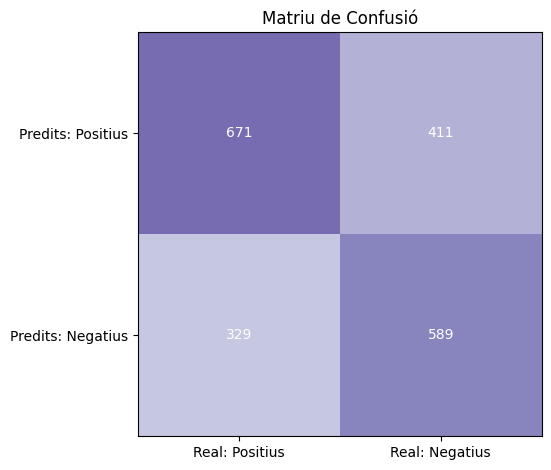

In [ ]:
TP, TN, FP, FN = prediccio(_positius, _negatius)
confusion_matrix(TP, TN, FP, FN)

### Experiment 2.1: Weighted Tokenizing

#### ROC Curve Plot

In [ ]:
def rocplot(fp_rates, tp_rates, models):
  # List of models
  # Plot ROC curve
  plt.plot(fp_rates, tp_rates, 'b-', label='ROC curve')
  plt.scatter(fp_rates, tp_rates, c='r', marker='o', label='Models')
  plt.plot([0, 1], [0, 1], 'r--', label='Random')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)

  # Mark the models on the ROC curve
  for i, model in enumerate(models):
      plt.annotate(model, (fp_rates[i], tp_rates[i]), textcoords="offset points", xytext=(5,5), ha='center')

  plt.xlim([min(fp_rates), max(fp_rates)])
  plt.ylim([min(tp_rates), max(tp_rates)])
  plt.show()


In [ ]:
i = 1
best_acc = (0,0)
tp_rates = []
fp_rates = []
models = []
while i <= 1.1:
  TP, TN, FP, FN = prediccio(_positius, _negatius, i)
  acc = (TP+TN)/(FP+FN+TP+TN)
  if acc > best_acc[0]:
    best_acc = (acc, i)
  i += 0.005
  tp_rates.append(TP)
  fp_rates.append(FP)
  models.append(round(i,3))


Positive reviews done!
TP:671, TN:589, FP:411, FN:329
Positive reviews done!
TP:669, TN:591, FP:409, FN:331
Positive reviews done!
TP:661, TN:602, FP:398, FN:339
Positive reviews done!
TP:653, TN:616, FP:384, FN:347
Positive reviews done!
TP:647, TN:626, FP:374, FN:353
Positive reviews done!
TP:638, TN:635, FP:365, FN:362
Positive reviews done!
TP:629, TN:644, FP:356, FN:371
Positive reviews done!
TP:619, TN:651, FP:349, FN:381
Positive reviews done!
TP:618, TN:660, FP:340, FN:382
Positive reviews done!
TP:609, TN:671, FP:329, FN:391
Positive reviews done!
TP:596, TN:674, FP:326, FN:404
Positive reviews done!
TP:589, TN:686, FP:314, FN:411
Positive reviews done!
TP:582, TN:694, FP:306, FN:418
Positive reviews done!
TP:569, TN:700, FP:300, FN:431
Positive reviews done!
TP:564, TN:707, FP:293, FN:436
Positive reviews done!
TP:557, TN:714, FP:286, FN:443
Positive reviews done!
TP:555, TN:719, FP:281, FN:445
Positive reviews done!
TP:545, TN:726, FP:274, FN:455
Positive reviews done!
TP:53

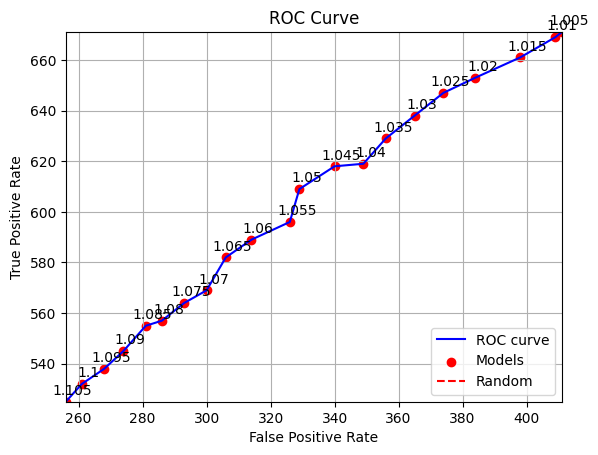

In [ ]:
rocplot(fp_rates, tp_rates, models)

In [ ]:
best_acc

(0.64, 1.044999999999999)

### Experiment 2.2: Weighted Adjectives

In [ ]:
def adjectius(texto):
    # Tokenizar el texto en oraciones y palabras
    oraciones = nltk.sent_tokenize(texto)
    palabras = [nltk.word_tokenize(oracion) for oracion in oraciones]
    
    # Etiquetar las partes del discurso de las palabras
    pos_palabras = [nltk.pos_tag(oracion) for oracion in palabras]
    
    # Filtrar solo los adjetivos
    adjetivos = []
    for oracion in pos_palabras:
        for palabra in oracion:
            if 'JJ' in palabra[1]:
                adjetivos.append(palabra[0])
    
    return adjetivos

In [ ]:
i = 1
best_acc = (0,0)
tp_rates = []
fp_rates = []
models = []
while i <= 1.1:
  TP, TN, FP, FN = prediccio(_positius, _negatius, i, adj = True)
  acc = (TP+TN)/(FP+FN+TP+TN)
  if acc > best_acc[0]:
    best_acc = (acc, i)
  i += 0.005
  tp_rates.append(TP)
  fp_rates.append(FP)
  models.append(round(i,3))


Positive reviews done!
TP:667, TN:636, FP:364, FN:333
Positive reviews done!
TP:667, TN:636, FP:364, FN:333
Positive reviews done!
TP:666, TN:637, FP:363, FN:334
Positive reviews done!
TP:662, TN:639, FP:361, FN:338
Positive reviews done!
TP:659, TN:644, FP:356, FN:341
Positive reviews done!
TP:652, TN:646, FP:354, FN:348
Positive reviews done!
TP:645, TN:652, FP:348, FN:355
Positive reviews done!
TP:641, TN:655, FP:345, FN:359
Positive reviews done!
TP:635, TN:658, FP:342, FN:365
Positive reviews done!
TP:632, TN:665, FP:335, FN:368
Positive reviews done!
TP:628, TN:671, FP:329, FN:372
Positive reviews done!
TP:627, TN:675, FP:325, FN:373
Positive reviews done!
TP:620, TN:680, FP:320, FN:380
Positive reviews done!
TP:611, TN:685, FP:315, FN:389
Positive reviews done!
TP:607, TN:689, FP:311, FN:393
Positive reviews done!
TP:599, TN:692, FP:308, FN:401
Positive reviews done!
TP:592, TN:695, FP:305, FN:408
Positive reviews done!
TP:587, TN:697, FP:303, FN:413
Positive reviews done!
TP:58

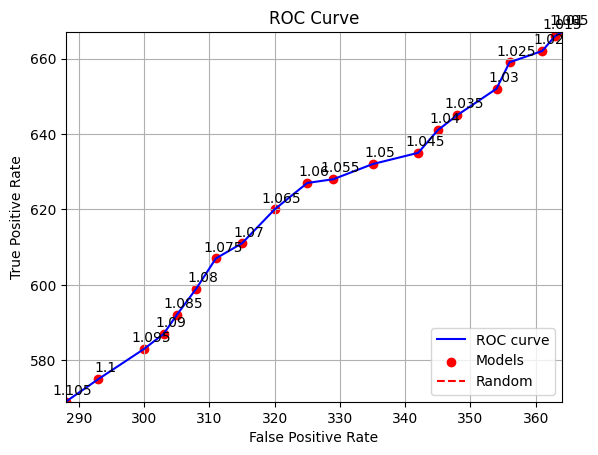

In [ ]:
rocplot(fp_rates, tp_rates, models)

In [ ]:
best_acc

(0.6515, 1)

In [ ]:
TP, TN, FP, FN = prediccio(_positius, _negatius, 1, adj = True)

Positive reviews done!
TP:667, TN:636, FP:364, FN:333


In [ ]:
print(f'Accuracy: {(TP+TN)/(FP+FN+TP+TN)}, F1 Score: {TP/(TP+FN)}')

Accuracy: 0.6515, F1 Score: 0.667


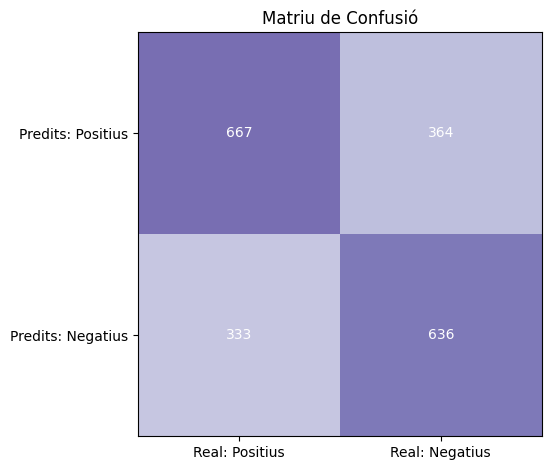

In [ ]:
confusion_matrix(TP, TN, FP, FN)

In [ ]:
print(f'Accuracy: {(TP+TN)/(FP+FN+TP+TN)}, F1 Score: {TP/(TP+((FN+FP)/2))}')

In [ ]:
confusion_matrix(TP, TN, FP, FN)